In [1]:
import pandas as pd
import os
import seaborn as sns
#from skbio.diversity import alpha_diversity
#from skbio.diversity import beta_diversity
#from skbio import TreeNode
from io import StringIO
#from skbio.stats.ordination import pcoa
from skbio.stats.composition import ancom


In [66]:
path_kraken = '//gfs/data/curated_metagenomes_kraken2/'

files_kraken = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_kraken):
    for file in f:
        if '.csv' in file:
            files_kraken.append(os.path.join(path_kraken, file))
print(files_kraken)

['//gfs/data/curated_metagenomes_kraken2/RampelliS_2015.csv', '//gfs/data/curated_metagenomes_kraken2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_kraken2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/Heitz-BuschartA_2016.csv', '//gfs/data/curated_metagenomes_kraken2/KarlssonFH_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LeChatelierE_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LiuW_2016.csv', '//gfs/data/curated_metagenomes_kraken2/LomanNJ_2013.csv', '//gfs/data/curated_metagenomes_kraken2/Obregon-TitoAJ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/QinJ_2012.csv', '//gfs/data/curated_metagenomes_kraken2/QinN_2014.csv', '//gfs/data/curated_metagenomes_kraken2/SchirmerM_2016.csv', '//gfs/data/curated_metagenomes_kraken2/VatanenT_2016.csv', '//gfs/data/curated_metagenomes_kraken2/VogtmannE_2016.csv', '//gfs/data/curated_metagenomes_kraken2/XieH_2016.csv', '//gfs/data/curated_metagenomes_kraken2

In [67]:
path_metaphlan = '//gfs/data/curated_metagenomes_metaphlan2/'

files_metaphlan = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_metaphlan):
    for file in f:
        if '.csv' in file:
            files_metaphlan.append(os.path.join(path_metaphlan, file))
print(files_metaphlan)

['//gfs/data/curated_metagenomes_metaphlan2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_metaphlan2/ChngKR_2016.csv']


In [6]:
def get_data_for_sample(path_to_file):
    dataset = path_to_file.split('/')[-1]
    df = pd.read_csv(path_to_file, delimiter = ',')
    df['Dataset'] = dataset
    df["Name"] = [n.strip() for n in df["Name"]]
    return df

In [7]:
class WrongRank(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

In [274]:
def get_table(df_name, table_files, rank='P'):

    for file in table_files:
        if df_name in file:
            index = table_files.index(file)
            
    df = get_data_for_sample(table_files[index])
    df_1 = df.loc[df["Name"] != "Chordata"]
    df_2 = df_1.loc[df['Rank'] == rank]
    if len(df_2) == 0:
        raise WrongRank(rank)
    
    df_2 = df_2[['Sample_ID', 'Name', 'Abundance']]
    
    # Normalizing Kraken output:
    tmp = df_2[["Sample_ID", "Abundance"]]
    tmp = tmp.set_index(tmp["Sample_ID"])
    summed = tmp.sum(level='Sample_ID')
    summed["SumAb"] = summed["Abundance"]
    summed = summed.drop(columns=["Abundance"])    
    j = df_2.join(summed, on="Sample_ID")
    def normalize(row):
        sample_ID = row.Sample_ID
        sum_v = row.SumAb
        v = row.Abundance
        row.Abundance = v/sum_v*100
        return row
    df_3 = j.apply(normalize, axis=1).drop(columns="SumAb")            
    
    table = df_3.pivot(index='Sample_ID', columns='Name', values='Abundance')

    return table

In [275]:
def compare_plot(dataset_name,  rank='P'):
    table_k = get_table(dataset_name, table_files = files_kraken, rank = rank.upper())
    table_k["Sample_ID"] = table_k.index
    table_k["Method"] = "Kraken2"
    table_k = table_k.set_index(["Sample_ID", "Method"])
    
    
    table_m = get_table(dataset_name, table_files = files_metaphlan, rank=rank.lower())
    table_m["Sample_ID"] = table_m.index
    table_m["Method"] = "MetaPhlan2"
    table_m = table_m.set_index(["Sample_ID", "Method"])
    
    concat = pd.concat([table_m, table_k])
    
    
    counts = {}
    counts_0 = {}
    to_drop = []
    for column in concat.columns:
        counts[column] = concat[column].loc[concat[column].notnull()].count()
        counts_0[column] = concat[column].loc[concat[column]<0.01].count()
        if (counts[column]-counts_0[column]) < concat.shape[1]/10:
            to_drop.append(column)
 
    c_2 = concat.drop(columns = to_drop)
    
    unpivot = pd.DataFrame(c_2.unstack(level=[1,0]))
    unpivot = unpivot.reset_index()
    
    unpivot["Abundance"] = unpivot[unpivot.columns[3]]
    unpivot[rank] = unpivot["level_0"]
    unpivot = unpivot[["Sample_ID", rank, "Method","Abundance"]]
    
    g = sns.catplot(x=rank, y="Abundance", hue="Method", data=unpivot,
                height=6, kind="bar", palette="muted")
    g.set_xticklabels(rotation=45)

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


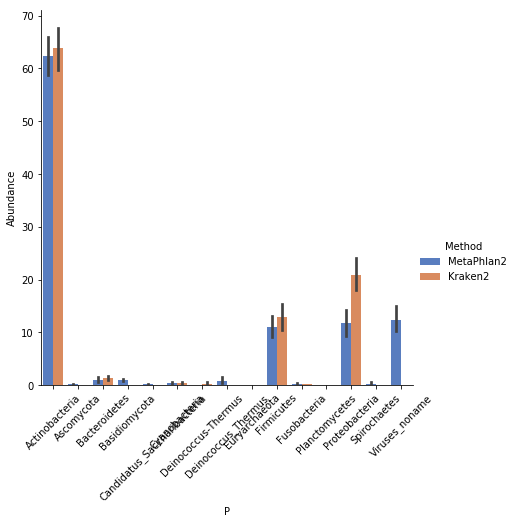

In [276]:
compare_plot("ChngKR_2016")

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


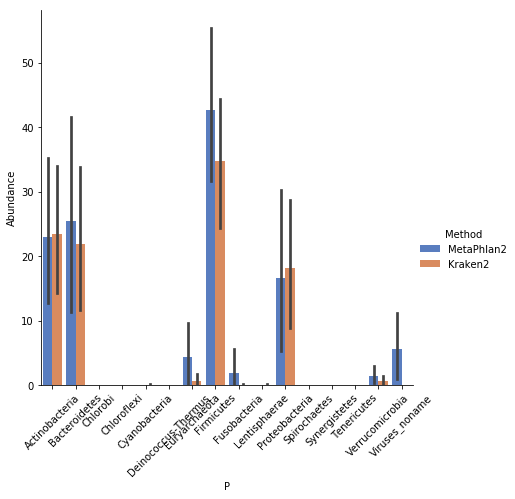

In [277]:
compare_plot("AsnicarF_2017")

In [134]:
table = get_table("AsnicarF_2017", table_files = files_kraken,
                     column_to_group = "DISEASE", rank='P')

   Unnamed: 0   Sample_ID            Dataset Rank                Name  \
0           0  SRR4052021  AsnicarF_2017.csv    U        unclassified   
1           1  SRR4052021  AsnicarF_2017.csv    R                root   
2           2  SRR4052021  AsnicarF_2017.csv   R1  cellular organisms   
3           3  SRR4052021  AsnicarF_2017.csv    D            Bacteria   
4           4  SRR4052021  AsnicarF_2017.csv    P      Proteobacteria   

   Abundance STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY  DISEASE  AGE  \
0       6.83         control     stool   MV_FEI1     ITA  healthy  1.0   
1      93.17         control     stool   MV_FEI1     ITA  healthy  1.0   
2      91.83         control     stool   MV_FEI1     ITA  healthy  1.0   
3      91.83         control     stool   MV_FEI1     ITA  healthy  1.0   
4      80.22         control     stool   MV_FEI1     ITA  healthy  1.0   

  AGE_CATEGORY  
0      newborn  
1      newborn  
2      newborn  
3      newborn  
4      newborn  


In [135]:
table = get_table("AsnicarF_2017", table_files = files_kraken,
                     column_to_group = "DISEASE", rank='P')
table["Sample_ID"] = table.index
table["Method"] = "Kraken2"
table = table.set_index(["Sample_ID", "Method"])

   Unnamed: 0   Sample_ID            Dataset Rank                Name  \
0           0  SRR4052021  AsnicarF_2017.csv    U        unclassified   
1           1  SRR4052021  AsnicarF_2017.csv    R                root   
2           2  SRR4052021  AsnicarF_2017.csv   R1  cellular organisms   
3           3  SRR4052021  AsnicarF_2017.csv    D            Bacteria   
4           4  SRR4052021  AsnicarF_2017.csv    P      Proteobacteria   

   Abundance STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY  DISEASE  AGE  \
0       6.83         control     stool   MV_FEI1     ITA  healthy  1.0   
1      93.17         control     stool   MV_FEI1     ITA  healthy  1.0   
2      91.83         control     stool   MV_FEI1     ITA  healthy  1.0   
3      91.83         control     stool   MV_FEI1     ITA  healthy  1.0   
4      80.22         control     stool   MV_FEI1     ITA  healthy  1.0   

  AGE_CATEGORY  
0      newborn  
1      newborn  
2      newborn  
3      newborn  
4      newborn  


In [50]:
table.head()

,Name,Acidobacteria,Actinobacteria,Aquificae,Armatimonadetes,Bacteroidetes,Caldiserica,Calditrichaeota,Candidatus Cloacimonetes,Candidatus Gracilibacteria,Candidatus Korarchaeota,...,Nitrospirae,Planctomycetes,Proteobacteria,Spirochaetes,Synergistetes,Tenericutes,Thaumarchaeota,Thermodesulfobacteria,Thermotogae,Verrucomicrobia
Sample_ID,Method,,,,,,,,,,,,,,,,,,,,,
SRR1950713,Kraken2,0.0,3.22,0.0,0.0,0.02,NaN,NaN,NaN,0.0,NaN,...,0.0,0.00,2.21,0.0,0.0,0.0,0.0,NaN,0.0,0.0
SRR1950714,Kraken2,0.0,8.34,0.0,0.0,0.04,NaN,0.0,NaN,0.0,NaN,...,0.0,0.00,3.58,0.0,0.0,0.0,0.0,NaN,0.0,0.0
SRR1950715,Kraken2,0.0,13.19,0.0,0.0,0.10,NaN,0.0,0.0,0.0,NaN,...,0.0,0.01,9.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR1950716,Kraken2,0.0,16.27,0.0,0.0,0.14,NaN,0.0,0.0,0.0,NaN,...,0.0,0.01,11.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR1950717,Kraken2,0.0,8.42,0.0,0.0,0.18,NaN,0.0,NaN,NaN,NaN,...,0.0,0.02,1.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
table_m = get_table("AsnicarF_2017", table_files = files_metaphlan,
                     column_to_group = "DISEASE", rank='p')
table_m["Sample_ID"] = table_m.index
table_m["Method"] = "MetaPhlan2"
table_m = table_m.set_index(["Sample_ID", "Method"])

   Unnamed: 0   Sample_ID            Dataset Rank            Name  Abundance  \
0           0  SRR4052021  AsnicarF_2017.csv    k        Bacteria   97.92389   
1           1  SRR4052021  AsnicarF_2017.csv    k         Viruses    2.07611   
2           2  SRR4052021  AsnicarF_2017.csv    p  Proteobacteria   78.59277   
3           3  SRR4052021  AsnicarF_2017.csv    p  Actinobacteria   12.60032   
4           4  SRR4052021  AsnicarF_2017.csv    p      Firmicutes    6.73081   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY  DISEASE  AGE AGE_CATEGORY  
0         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  
1         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  
2         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  
3         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  
4         control     stool   MV_FEI1     ITA  healthy  1.0      newborn  


In [137]:
concat = pd.concat([table_m, table])

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [138]:
concat.head()

,,Acidobacteria,Actinobacteria,Aquificae,Armatimonadetes,Bacteroidetes,Caldiserica,Calditrichaeota,Candidatus Cloacimonetes,Candidatus Gracilibacteria,Candidatus Korarchaeota,...,Planctomycetes,Proteobacteria,Spirochaetes,Synergistetes,Tenericutes,Thaumarchaeota,Thermodesulfobacteria,Thermotogae,Verrucomicrobia,Viruses_noname
Sample_ID,Method,,,,,,,,,,,,,,,,,,,,,
SRR4052021,MetaPhlan2,NaN,12.600319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,78.592762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.07611
SRR4052022,MetaPhlan2,NaN,60.094890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.162060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26196
SRR4052023,MetaPhlan2,NaN,0.645960,NaN,NaN,66.120523,NaN,NaN,NaN,NaN,NaN,...,NaN,0.652970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR4052024,MetaPhlan2,NaN,1.194430,NaN,NaN,89.353810,NaN,NaN,NaN,NaN,NaN,...,NaN,1.355890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR4052025,MetaPhlan2,NaN,48.565785,NaN,NaN,26.538393,NaN,NaN,NaN,NaN,NaN,...,NaN,1.123800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
c = concat.sort_values(by='Sample_ID', ascending=False)

In [140]:
c.head()

Acidobacteria  Actinobacteria  Aquificae  \
Sample_ID  Method                                                 
SRR4052044 Kraken2          0.044014        2.596831        0.0   
           MetaPhlan2            NaN        1.582650        NaN   
SRR4052043 MetaPhlan2            NaN        1.482590        NaN   
           Kraken2          0.000000        3.745541        0.0   
SRR4052042 MetaPhlan2            NaN       74.362743        NaN   

                       Armatimonadetes  Bacteroidetes  Caldiserica  \
Sample_ID  Method                                                    
SRR4052044 Kraken2                 0.0      44.454225          0.0   
           MetaPhlan2              NaN      37.018430          NaN   
SRR4052043 MetaPhlan2              NaN      72.743800          NaN   
           Kraken2                 0.0      61.177170          0.0   
SRR4052042 MetaPhlan2              NaN       0.808720          NaN   

                       Calditrichaeota  Candidatus Cloacimonetes  \
Sample_ID  Method                                                  
SRR4052044 Kraken2                 0.0                       0.0   
           MetaPhlan2              NaN                       NaN   
SRR4052043 MetaPhlan2              NaN                       NaN   
           Kraken2                 0.0                       0.0   
SRR4052042 MetaPhlan2              NaN                       NaN   

                       Candidatus Gracilibacteria  Candidatus Korarchaeota  \
Sample_ID  Method                                                            
SRR4052044 Kraken2                            0.0                      NaN   
           MetaPhlan2                         NaN                      NaN   
SRR4052043 MetaPhlan2                         NaN                      NaN   
           Kraken2                            NaN                      NaN   
SRR4052042 MetaPhlan2                         NaN                      NaN   

                            ...        Planctomycetes  Proteobacteria  \
Sample_ID  Method           ...                                         
SRR4052044 Kraken2          ...              0.044014        6.426056   
           MetaPhlan2       ...                   NaN        2.538820   
SRR4052043 MetaPhlan2       ...                   NaN        0.983980   
           Kraken2          ...              0.059453        3.567182   
SRR4052042 MetaPhlan2       ...                   NaN        0.250720   

                       Spirochaetes  Synergistetes  Tenericutes  \
Sample_ID  Method                                                 
SRR4052044 Kraken2         0.132042       0.044014     0.132042   
           MetaPhlan2           NaN            NaN          NaN   
SRR4052043 MetaPhlan2           NaN            NaN          NaN   
           Kraken2         0.059453       0.000000     0.000000   
SRR4052042 MetaPhlan2           NaN            NaN          NaN   

                       Thaumarchaeota  Thermodesulfobacteria  Thermotogae  \
Sample_ID  Method                                                           
SRR4052044 Kraken2                0.0                    0.0     0.044014   
           MetaPhlan2             NaN                    NaN          NaN   
SRR4052043 MetaPhlan2             NaN                    NaN          NaN   
           Kraken2                0.0                    0.0     0.000000   
SRR4052042 MetaPhlan2             NaN                    NaN          NaN   

                       Verrucomicrobia  Viruses_noname  
Sample_ID  Method                                       
SRR4052044 Kraken2            1.144366             NaN  
           MetaPhlan2         0.731910             NaN  
SRR4052043 MetaPhlan2         0.056190             NaN  
           Kraken2            0.178359             NaN  
SRR4052042 MetaPhlan2         0.010450             NaN  

[5 rows x 44 columns]

In [144]:
c.sum(axis=1)[0:6]

Sample_ID   Method    
SRR4052044  Kraken2       100.0
            MetaPhlan2    100.0
SRR4052043  MetaPhlan2    100.0
            Kraken2       100.0
SRR4052042  MetaPhlan2    100.0
            Kraken2       100.0
dtype: float64

In [179]:
counts = {}
counts_0 = {}
to_drop = []
print(c.shape)
for column in c.columns:
    counts[column] = c[column].loc[c[column].notnull()].count()
    counts_0[column] = c[column].loc[c[column]<0.01].count()
    print(column, counts[column], counts_0[column])
    if (counts[column]-counts_0[column]) < c.shape[1]/4:
        to_drop.append(column)
c_2 = c.drop(columns = to_drop)

(47, 44)
Acidobacteria 19 15
Actinobacteria 46 0
Aquificae 16 16
Armatimonadetes 14 14
Bacteroidetes 40 2
Caldiserica 12 12
Calditrichaeota 12 12
Candidatus Cloacimonetes 11 11
Candidatus Gracilibacteria 7 7
Candidatus Korarchaeota 2 2
Candidatus Micrarchaeota 2 2
Candidatus Saccharibacteria 16 16
Candidatus_Saccharibacteria 1 1
Chlamydiae 17 17
Chlorobi 18 11
Chloroflexi 17 11
Chordata 24 5
Chrysiogenetes 13 13
Coprothermobacterota 7 7
Crenarchaeota 18 17
Cyanobacteria 22 5
Deferribacteres 17 16
Deinococcus-Thermus 20 12
Dictyoglomi 16 16
Elusimicrobia 15 15
Euryarchaeota 30 7
Fibrobacteres 14 13
Firmicutes 47 0
Fusobacteria 26 8
Gemmatimonadetes 15 15
Ignavibacteriae 17 16
Kiritimatiellaeota 10 10
Lentisphaerae 13 7
Nitrospirae 16 15
Planctomycetes 19 15
Proteobacteria 43 0
Spirochaetes 20 7
Synergistetes 17 12
Tenericutes 19 9
Thaumarchaeota 14 14
Thermodesulfobacteria 16 16
Thermotogae 18 15
Verrucomicrobia 26 10
Viruses_noname 7 0


In [180]:
c_2.shape

(47, 10)

In [221]:
c_2.head()

Actinobacteria  Bacteroidetes  Chordata  Cyanobacteria  \
Sample_ID  Method                                                               
SRR4052044 Kraken2           2.596831      44.454225  0.132042       0.132042   
           MetaPhlan2        1.582650      37.018430       NaN            NaN   
SRR4052043 MetaPhlan2        1.482590      72.743800       NaN            NaN   
           Kraken2           3.745541      61.177170  0.118906       0.118906   
SRR4052042 MetaPhlan2       74.362743       0.808720       NaN            NaN   

                       Euryarchaeota  Firmicutes  Fusobacteria  \
Sample_ID  Method                                                
SRR4052044 Kraken2          9.419014   34.903169      0.044014   
           MetaPhlan2      18.511000   39.617190           NaN   
SRR4052043 MetaPhlan2       0.118050   24.615390           NaN   
           Kraken2          0.297265   30.439952      0.000000   
SRR4052042 MetaPhlan2            NaN   24.567368           NaN   

                       Proteobacteria  Spirochaetes  Verrucomicrobia  
Sample_ID  Method                                                     
SRR4052044 Kraken2           6.426056      0.132042         1.144366  
           MetaPhlan2        2.538820           NaN         0.731910  
SRR4052043 MetaPhlan2        0.983980           NaN         0.056190  
           Kraken2           3.567182      0.059453         0.178359  
SRR4052042 MetaPhlan2        0.250720           NaN         0.010450

In [215]:
unpivot = pd.DataFrame(c_2.unstack(level=[1,0]))
unpivot = unpivot.reset_index()

In [217]:
unpivot["Abundance"] = unpivot[unpivot.columns[3]]
unpivot["Phylum"] = unpivot["level_0"]
unpivot = unpivot[["Sample_ID", "Phylum", "Method","Abundance"]]

In [218]:
unpivot.head()

,Sample_ID,Phylum,Method,Abundance
0,SRR4052044,Actinobacteria,Kraken2,2.596831
1,SRR4052044,Actinobacteria,MetaPhlan2,1.582650
2,SRR4052043,Actinobacteria,MetaPhlan2,1.482590
3,SRR4052043,Actinobacteria,Kraken2,3.745541
4,SRR4052042,Actinobacteria,MetaPhlan2,74.362743


In [220]:
unpivot.shape

(470, 4)

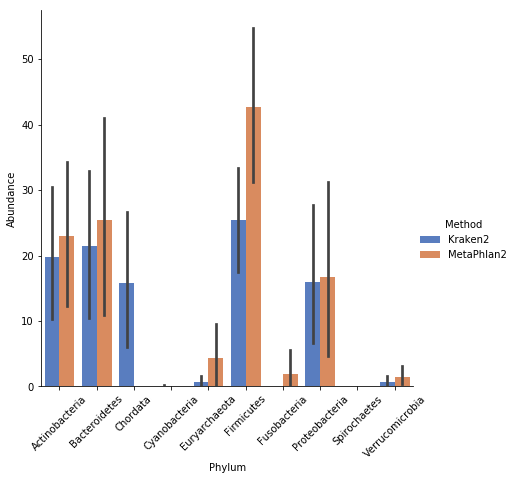

In [219]:
g = sns.catplot(x="Phylum", y="Abundance", hue="Method", data=unpivot,
                height=6, kind="bar", palette="muted")
g.set_xticklabels(rotation=45)

In [ ]:
g = sns.catplot(x="Phylum", y="Abundance", hue="Method", data=unpivot,
                height=6, kind="bar", palette="muted")
g.set_xticklabels(rotation=45)

In [278]:
dataset_name = "AsnicarF_2017"
rank='P'

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


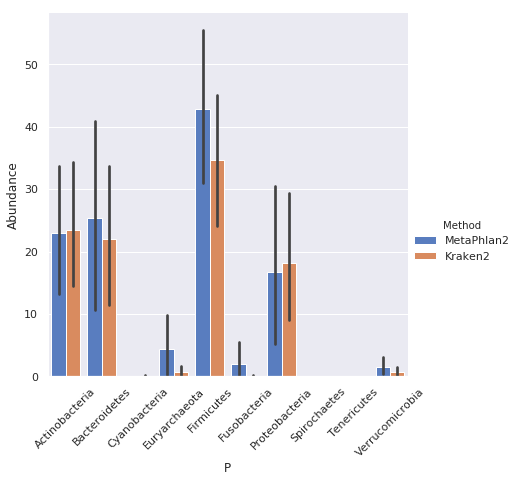

In [291]:
table_k = get_table(dataset_name, table_files = files_kraken, rank = rank.upper())
table_k["Sample_ID"] = table_k.index
table_k["Method"] = "Kraken2"
table_k = table_k.set_index(["Sample_ID", "Method"])


table_m = get_table(dataset_name, table_files = files_metaphlan, rank=rank.lower())
table_m["Sample_ID"] = table_m.index
table_m["Method"] = "MetaPhlan2"
table_m = table_m.set_index(["Sample_ID", "Method"])

concat = pd.concat([table_m, table_k])


counts = {}
counts_0 = {}
to_drop = []
for column in concat.columns:
    counts[column] = concat[column].loc[concat[column].notnull()].count()
    counts_0[column] = concat[column].loc[concat[column]<0.01].count()
    if (counts[column]-counts_0[column]) < concat.shape[1]/5:
        to_drop.append(column)

c_2 = concat.drop(columns = to_drop)

unpivot = pd.DataFrame(c_2.unstack(level=[1,0]))
unpivot = unpivot.reset_index()

unpivot["Abundance"] = unpivot[unpivot.columns[3]]
unpivot[rank] = unpivot["level_0"]
unpivot = unpivot[["Sample_ID", rank, "Method","Abundance"]]

g = sns.catplot(x=rank, y="Abundance", hue="Method", data=unpivot,
            height=6, kind="bar", palette="muted")
g.set_xticklabels(rotation=45)

In [280]:
unpivot.head()

,Sample_ID,P,Method,Abundance
0,SRR4052021,Actinobacteria,MetaPhlan2,12.600319
1,SRR4052022,Actinobacteria,MetaPhlan2,60.094890
2,SRR4052023,Actinobacteria,MetaPhlan2,0.645960
3,SRR4052024,Actinobacteria,MetaPhlan2,1.194430
4,SRR4052025,Actinobacteria,MetaPhlan2,48.565785


In [ ]:
g = sns.catplot(x=rank, y="Abundance", hue="Method", data=unpivot,
            height=6, kind="bar", palette="muted")

TypeError: set_xticklabels() missing 1 required positional argument: 'labels'

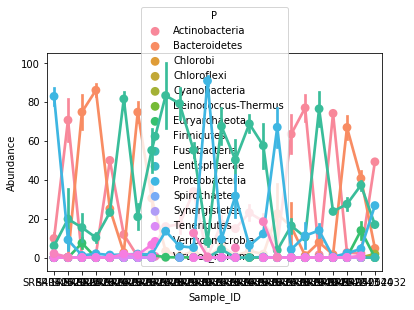

In [286]:
g2= sns.pointplot(x="Sample_ID", y="Abundance", hue=rank,
              data=unpivot)

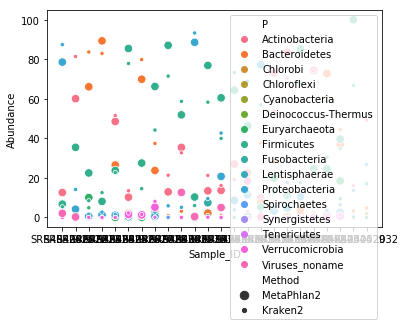

In [288]:
sns.scatterplot(x="Sample_ID", y="Abundance",
                hue=rank, size="Method",
                data=unpivot)

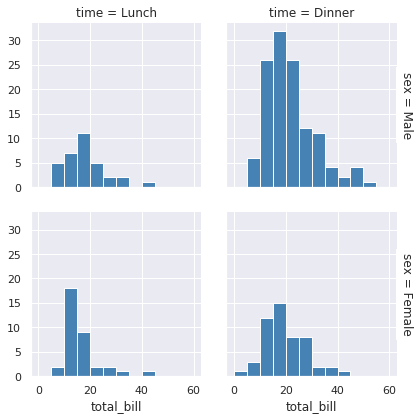

In [289]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

tips = sns.load_dataset("tips")
g = sns.FacetGrid(tips, row="sex", col="time", margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "total_bill", color="steelblue", bins=bins)

In [ ]:
g = sns.catplot(x=rank, y="Abundance", hue=rank, data=unpivot,
            height=6, kind="bar", palette="muted")

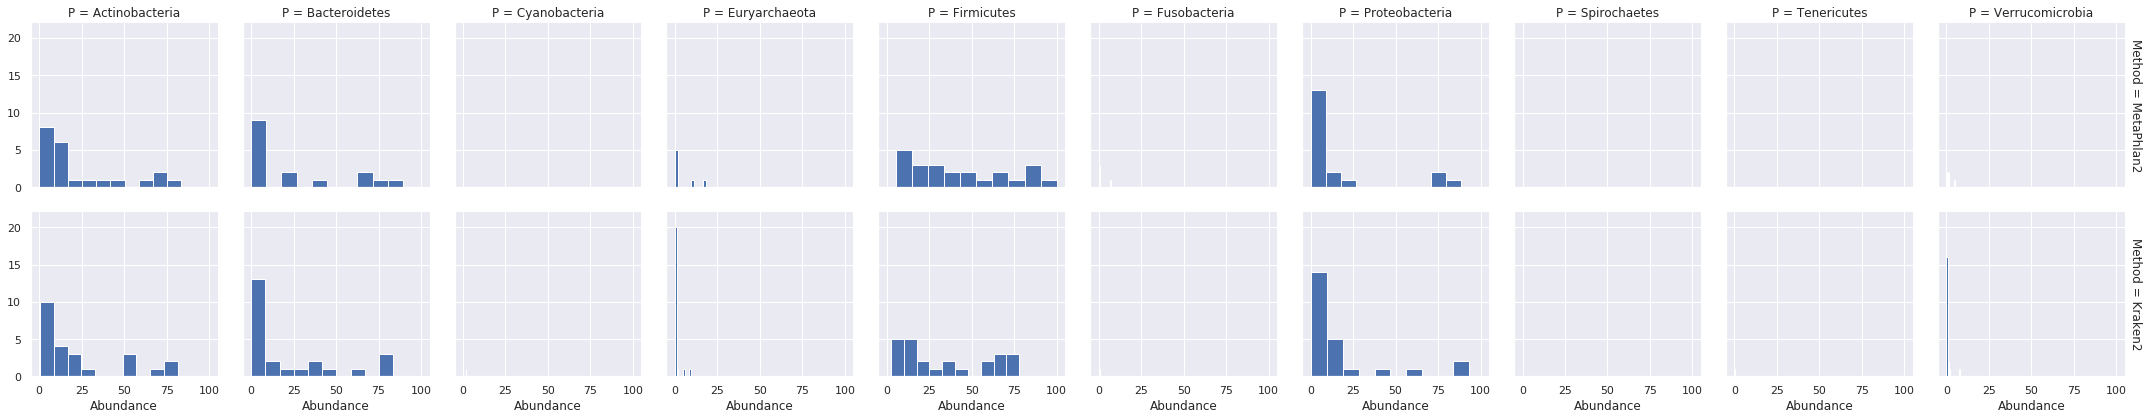

In [298]:
g_3 = sns.FacetGrid(unpivot, row="Method", col=rank, margin_titles=True)
g_3.map(plt.hist, "Abundance")